In [103]:
import pandas as pd
import seaborn as sns
import warnings
import re
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import json

warnings.filterwarnings(action='ignore')

In [68]:
df=pd.read_csv('../data/raw_data/origin_data.csv')

## Title 추가

In [69]:
def get_title(text):
    return text.split("\n")[0].strip("@")

df['title']=df['context'].apply(lambda x: get_title(x))

# 길이관련 분석

In [70]:
df['answers']=df['answers'].apply(lambda x:eval(x))                      # dict vs string ...

df['con_len'] = df['context'].apply(lambda x: len(x))
df['qu_len'] = df['question'].apply(lambda x: len(x))
df['ans_len']=[len((df['answers'][i])['text']) for i in range(len(df))]

# `시각화를 위해` 정수형의 category -> 질문 유형 추가

In [71]:
question_mark_dict={1:'1 : When(term)',
                    2:'2 :When(date)',
                    3:'3 : Who(action)',
                    4:'4 : Who(role)',
                    5:'5 : Why(action)',
                    6:'6 : What(indicator)',
                    7:'7 : What(conference)'}

category_list=df['category']

for i in range(len(category_list)):
    for key in question_mark_dict.keys():
        if category_list[i]==key:
            category_list[i]=question_mark_dict[key]

df['category']=category_list

# 데이터의 형태

In [72]:
df.head(5)

,category,document_id,question,answers,context,ans_len,title,con_len,qu_len
0,1 : When(term),603489,제178회 완주군의회 임시회 회기는 언제로 결정됐어?,"{'answer_start': 144, 'text': '4월 20일부터 4월 27일...",@제178회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사일정...,21,제178회 완주군의회(임시회) 제 1 차 본회의회의록,242,29
1,3 : Who(action),603489,제178회 완주군의회 임시회 회기를 발의한 사람은 누구인가?,"{'answer_start': 119, 'text': '김상식 위원장 외 3인의 의원'}",@제178회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사일정...,16,제178회 완주군의회(임시회) 제 1 차 본회의회의록,242,33
2,7 : What(conference),604003,제7대 완주군의회 후반기 상임위원회 의원 선임건을 상정한 회의는 어떤거야?,"{'answer_start': 1, 'text': '제214회 완주군의회(임시회) ...",@제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록@\n\n의석을 정돈하여...,26,제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록,908,41
3,4 : Who(role),604003,산업건설위원회 위원들은 누구인가?,"{'answer_start': 656, 'text': '서남용 의원님, 윤수봉 의원...",@제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록@\n\n의석을 정돈하여...,43,제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록,908,18
4,6 : What(indicator),603644,완주군의회 의원 의정활동비등 지급에 관한 조례중 개정조례안을 발의한 의원은 몇 명이야?,"{'answer_start': 435, 'text': '9인'}",@제109회 전라북도 완주군의회 (임시회) 제2호 본 회 의 회 의 록@\n\n의사...,2,제109회 전라북도 완주군의회 (임시회) 제2호 본 회 의 회 의 록,1111,48


# EDA

# Train data의 길이
- [MRC EDA](https://github.com/boostcampaitech3/level2-mrc-level2-nlp-09/blob/master/EDA/EDA.ipynb)와 유사함

Text(0.5, 1.0, 'Density of answer length')

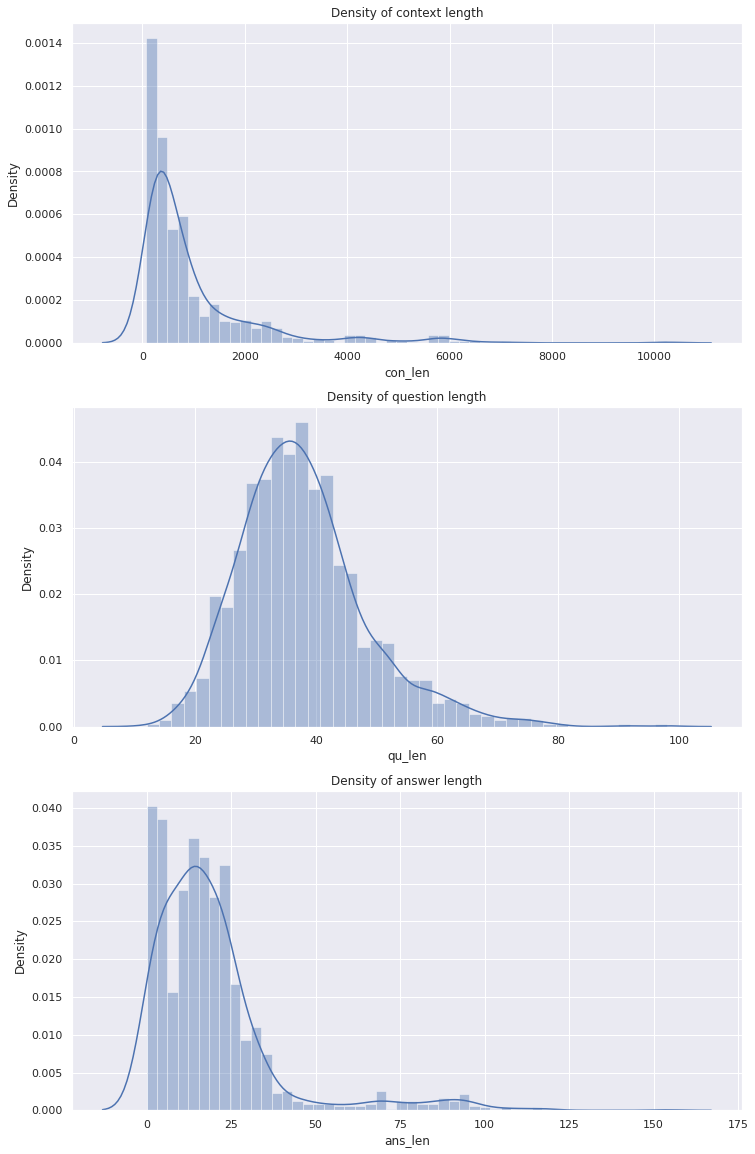

In [73]:
fig, axes = plt.subplots(3, 1, figsize=(12, 20))

g = sns.distplot(df['con_len'], ax=axes[0])
# g = sns.violinplot(data=train_df, x='con_len', ax=ax)
axes[0].set_xlabel(g.get_xlabel(), fontsize=12)
axes[0].set_ylabel(g.get_ylabel(), fontsize=12) 
axes[0].set_title('Density of context length')


g = sns.distplot(df['qu_len'], ax=axes[1])
axes[1].set_xlabel(g.get_xlabel(), fontsize=12)
axes[1].set_ylabel(g.get_ylabel(), fontsize=12) 
axes[1].set_title('Density of question length')


g = sns.distplot(df['ans_len'], ax=axes[2])
axes[2].set_xlabel(g.get_xlabel(), fontsize=12)
axes[2].set_ylabel(g.get_ylabel(), fontsize=12) 
axes[2].set_title('Density of answer length')

## 통계치
- 참고하여 전처리에서 제거

In [74]:
df[["con_len","qu_len","ans_len"]].describe()

,con_len,qu_len,ans_len
count,1539.000000,1539.000000,1539.000000
mean,981.989604,37.847953,19.225471
std,1242.065066,10.561247,18.845356
min,78.000000,12.000000,0.000000
25%,274.000000,31.000000,7.000000
50%,525.000000,37.000000,16.000000
75%,1044.500000,43.000000,23.000000
max,10253.000000,98.000000,154.000000


## 결측치
- 참고하여 전처리에서 제거

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     1539 non-null   object
 1   document_id  1539 non-null   int64 
 2   question     1539 non-null   object
 3   answers      1539 non-null   object
 4   context      1539 non-null   object
 5   ans_len      1539 non-null   int64 
 6   title        1539 non-null   object
 7   con_len      1539 non-null   int64 
 8   qu_len       1539 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 108.3+ KB


## 중복

In [76]:
print(f"카테고리 수 : {df['category'].nunique()}")
print(f"unique document_id 수 : {df['document_id'].nunique()}")
print(f"unique context 수 : : {df['context'].nunique()}")

카테고리 수 : 7
unique document_id 수 : 857
unique context 수 : : 857


# 질문 유형 별 개수

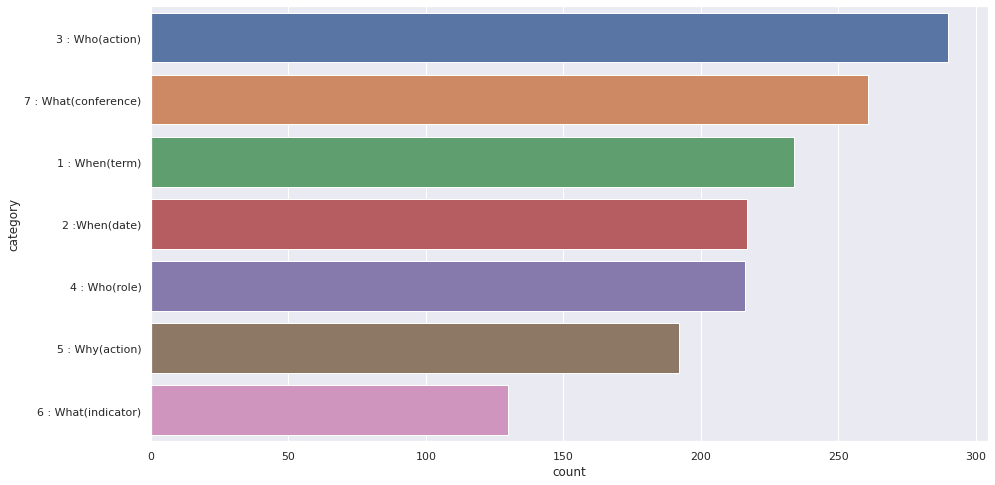

In [12]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)

# 질문 유형 별 답변의 길이

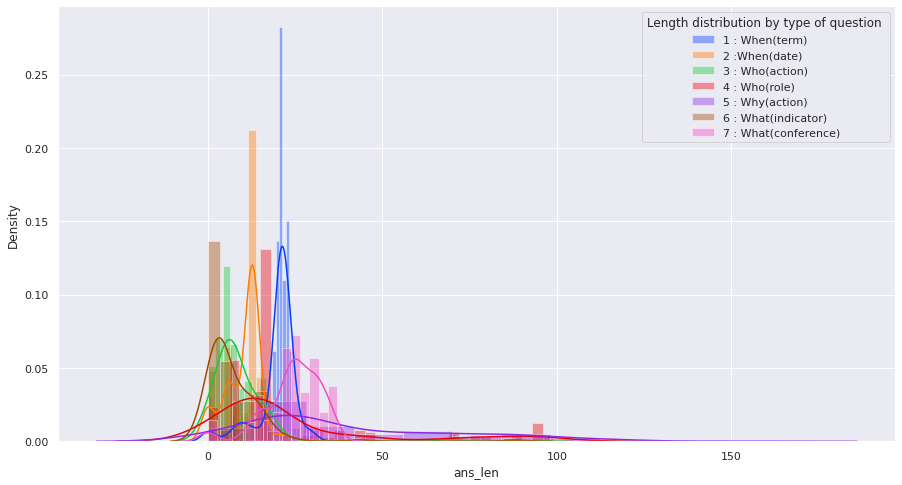

In [98]:
category_sort=sorted(df.category.unique(),key=lambda x : x[0])
palette=sns.color_palette("bright")

for i in range(len(category_sort)):
    sns.distplot(df[df.category ==category_sort[i]]["ans_len"],
             color=palette[i], 
             label=category_sort[i])
plt.legend(title="Length distribution by type of question ")
plt.show()

# KorQuAD의 유형별 분포

![korquad](https://user-images.githubusercontent.com/46811558/169752414-9afcfaf2-edd6-4d54-8ba8-bf34a2d2b335.png)

# [가이드라인](http://docs.google.com/document/d/113ta_VFzTiys3pfLDbOLUC-Ecr3Z9fH0/edit?usp=drive_web&ouid=101066135644630336307&rtpof=true) 참고한 표  

In [13]:
category_df=pd.DataFrame()
column_list=['의문사','질문 패턴','답변 유형']
mark_list=['When(기간)','When(일시)','Who(능동주, 행동)','Who(피동주, 역할)','Why(행동, 의견)','What(지표)','What(회의)']
answer_list=['기간(날짜, 시간)','일시(날짜, 시간)','사람(들)','사람','명사구/기타','숫자(금액, 단위)','명사구']
qu_list=['<사건>의 기간은?','<사건>는 언제 진행되는가?','<행동>을 수행한 사람은 누구인가?','<역할>을 맡게된 사람은 누구인가?','<행동>을 한 이유는 무엇인가?','<사건>의 나온 <지표>는 얼마인가?','<사건>를 다루고 있는 회의는?']

category_df[column_list[0]]=mark_list
category_df[column_list[1]]=qu_list
category_df[column_list[2]]=answer_list

category_df.index=category_df.index + 1
category_df['count']=list(df['category'].value_counts().sort_index())

In [14]:
category_df

,의문사,질문 패턴,답변 유형,count
1,When(기간),<사건>의 기간은?,"기간(날짜, 시간)",234
2,When(일시),<사건>는 언제 진행되는가?,"일시(날짜, 시간)",217
3,"Who(능동주, 행동)",<행동>을 수행한 사람은 누구인가?,사람(들),290
4,"Who(피동주, 역할)",<역할>을 맡게된 사람은 누구인가?,사람,216
5,"Why(행동, 의견)",<행동>을 한 이유는 무엇인가?,명사구/기타,192
6,What(지표),<사건>의 나온 <지표>는 얼마인가?,"숫자(금액, 단위)",130
7,What(회의),<사건>를 다루고 있는 회의는?,명사구,261


# EDA(Tokenizer)

In [15]:
from transformers import AutoModel, AutoTokenizer

MODEL_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [16]:
df['con_tok_len'] = df['context'].apply(lambda x: len(tokenizer.tokenize(x)))
df['qu_tok_len'] = df['question'].apply(lambda x: len(tokenizer.tokenize(x)))
df['ans_tok_len']=[len(tokenizer.tokenize(df['answers'][i]['text'])) for i in range(len(df))]

Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


In [22]:
df.head(5)

,category,document_id,question,answers,context,title,con_len,qu_len,ans_len,con_tok_len,qu_tok_len,ans_tok_len
0,1 : When(term),603489,제178회 완주군의회 임시회 회기는 언제로 결정됐어?,"{'answer_start': 144, 'text': '4월 20일부터 4월 27일...",@제178회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사일정...,제178회 완주군의회(임시회) 제 1 차 본회의회의록,242,29,21,124,16,14
1,3 : Who(action),603489,제178회 완주군의회 임시회 회기를 발의한 사람은 누구인가?,"{'answer_start': 119, 'text': '김상식 위원장 외 3인의 의원'}",@제178회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사일정...,제178회 완주군의회(임시회) 제 1 차 본회의회의록,242,33,16,124,18,8
2,7 : What(conference),604003,제7대 완주군의회 후반기 상임위원회 의원 선임건을 상정한 회의는 어떤거야?,"{'answer_start': 1, 'text': '제214회 완주군의회(임시회) ...",@제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록@\n\n의석을 정돈하여...,제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록,908,41,26,470,21,16
3,4 : Who(role),604003,산업건설위원회 위원들은 누구인가?,"{'answer_start': 656, 'text': '서남용 의원님, 윤수봉 의원...",@제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록@\n\n의석을 정돈하여...,제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록,908,18,43,470,10,26
4,6 : What(indicator),603644,완주군의회 의원 의정활동비등 지급에 관한 조례중 개정조례안을 발의한 의원은 몇 명이야?,"{'answer_start': 435, 'text': '9인'}",@제109회 전라북도 완주군의회 (임시회) 제2호 본 회 의 회 의 록@\n\n의사...,제109회 전라북도 완주군의회 (임시회) 제2호 본 회 의 회 의 록,1111,48,2,576,28,2


# Tokenize 이후 Train data의 길이
- [MRC EDA](https://github.com/boostcampaitech3/level2-mrc-level2-nlp-09/blob/master/EDA/EDA_tokenizer.ipynb)와 유사함

Text(0.5, 1.0, 'Density of tokenized answer length')

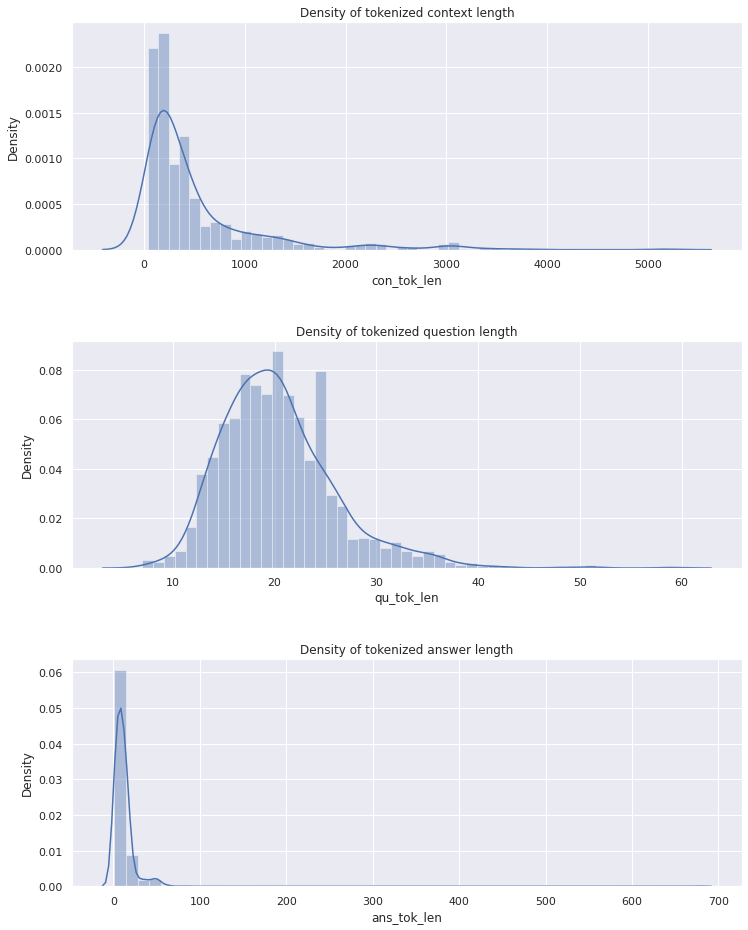

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(12, 15))
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.4)

g = sns.distplot(df['con_tok_len'], ax=axes[0])
axes[0].set_xlabel(g.get_xlabel(), fontsize=12)
axes[0].set_ylabel(g.get_ylabel(), fontsize=12) 
axes[0].set_title('Density of tokenized context length')


g = sns.distplot(df['qu_tok_len'], ax=axes[1])
axes[1].set_xlabel(g.get_xlabel(), fontsize=12)
axes[1].set_ylabel(g.get_ylabel(), fontsize=12) 
axes[1].set_title('Density of tokenized question length')

g = sns.distplot(df['ans_tok_len'], ax=axes[2])
axes[2].set_xlabel(g.get_xlabel(), fontsize=12)
axes[2].set_ylabel(g.get_ylabel(), fontsize=12) 
axes[2].set_title('Density of tokenized answer length')

## 통계치

In [24]:
df.describe()

,document_id,con_len,qu_len,ans_len,con_tok_len,qu_tok_len,ans_tok_len
count,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000
mean,603889.197403,982.737013,37.860390,20.274026,517.840260,20.327273,11.407143
std,235.974269,1242.007843,10.569089,39.132158,651.236069,5.662311,19.776032
min,603471.000000,78.000000,12.000000,1.000000,40.000000,7.000000,1.000000
25%,603699.750000,274.000000,31.000000,7.000000,144.000000,16.750000,4.000000
50%,603872.500000,526.000000,37.000000,16.000000,282.000000,20.000000,8.500000
75%,604079.250000,1054.000000,43.000000,23.000000,543.000000,23.000000,14.000000
max,604331.000000,10253.000000,98.000000,1367.000000,5176.000000,59.000000,678.000000


# Answer의 위치
## `max_seq_length, max_answer_length, doc_stride` 실험의 근거

### Tokenize 전

In [22]:
df_answer=df[['category','document_id','question','answers','context','con_len','ans_len']]
df_answer['ans_start']=[df_answer['answers'][i]['answer_start'] for i in range(len(df_answer))]
df_answer['ans_finish']=[df_answer['answers'][i]['answer_start']+len(df_answer['answers'][i]['text']) for i in range(len(df_answer))]
df_answer['ans_ratio']=df_answer['ans_finish']/df_answer['con_len']

In [23]:
df_answer.head(3)

,category,document_id,question,answers,context,con_len,ans_len,ans_start,ans_finish,ans_ratio
0,1 : When(term),603489,제178회 완주군의회 임시회 회기는 언제로 결정됐어?,"{'answer_start': 144, 'text': '4월 20일부터 4월 27일...",@제178회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사일정...,242,21,144,165,0.681818
1,3 : Who(action),603489,제178회 완주군의회 임시회 회기를 발의한 사람은 누구인가?,"{'answer_start': 119, 'text': '김상식 위원장 외 3인의 의원'}",@제178회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사일정...,242,16,119,135,0.557851
2,7 : What(conference),604003,제7대 완주군의회 후반기 상임위원회 의원 선임건을 상정한 회의는 어떤거야?,"{'answer_start': 1, 'text': '제214회 완주군의회(임시회) ...",@제214회 완주군의회(임시회) 제1차 본 회 의 회 의 록@\n\n의석을 정돈하여...,908,26,1,27,0.029736


# 문장의 전체길이에서 답변의 끝 index의 `비율`(DPR 근거)

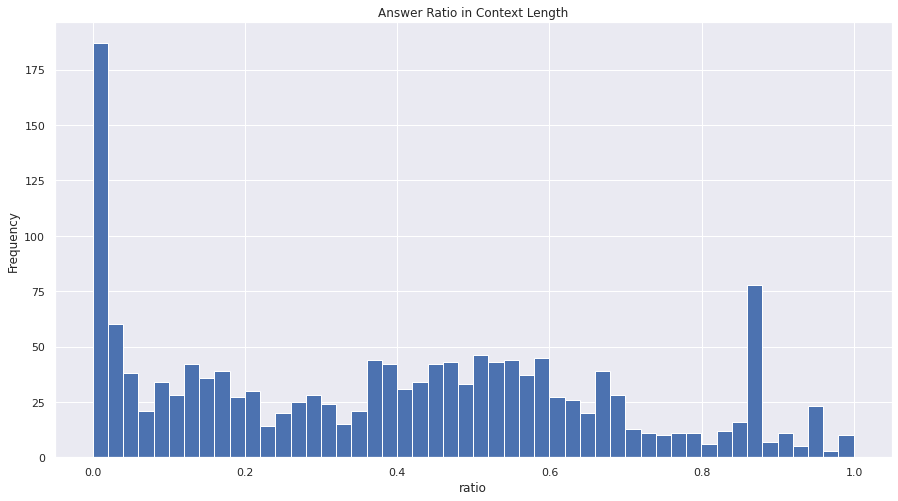

In [29]:
plt.xlabel("ratio")
plt.ylabel("Frequency")
plt.title("Answer Ratio in Context Length")
plt.hist(df_answer['ans_ratio'].sort_values(),bins=50)
plt.show()

### Tokenizer 이후
- 답변의 끝 index가 512를 넘는 것은 전체 1540개 중 72개

In [31]:
def get_tok_index(tok_tuple_list):
    for i in range(len(tok_tuple_list[0])):
        if tok_tuple_list[0][i:i+len(tok_tuple_list[1])]==tok_tuple_list[1]:
            return (i,i+len(tok_tuple_list[1]))

tok_list=[(tokenizer.tokenize(df['context'][i]),tokenizer.tokenize(df['answers'][i]['text'])) for i in range(len(df))]
df['tok_list']=tok_list
df['tok_index']=df['tok_list'].apply(lambda x : get_tok_index(x))
df['tok_finish_index']=df['tok_index'].apply(lambda x: x[1])

# Tokenize 이후 답변의 끝 index `길이`(max_length 근거)

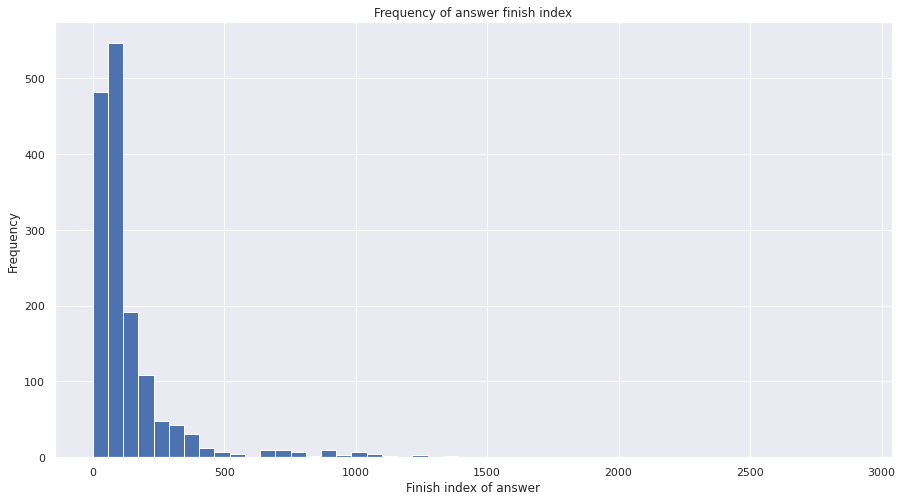

In [33]:
plt.xlabel("Finish index of answer")
plt.ylabel("Frequency")
plt.title("Frequency of answer finish index")
plt.hist(df['tok_finish_index'],bins=50)
plt.show()

## 회의록
- 165개의 회의록의 데이터
- 회의록에서 질문의 최소개수는 3개, 최대 개수는 25개

In [34]:
def get_title(text):
    return text.split("\n")[0].strip("@")

df['title']=df['context'].apply(lambda x: get_title(x))

In [35]:
df.groupby('title').count().sort_values('category')[['question','answers']]

,question,answers
title,,
제228회 완주군의회(임시회) 제1차 본 회 의 회 의 록,3,3
제170회 완주군의회(임시회) 제 1 차 본회의회의록,4,4
제59회 전라북도 완주군의회 (임시회) 제1호 본 회 의 회 의 록,4,4
제195회 완주군의회(임시회) 제 1 차 본회의회의록,4,4
제205회 완주군의회(임시회) 제 1 차 본회의회의록,4,4
...,...,...
제103회 전라북도 완주군의회 (임시회) 제1호 본 회 의 회 의 록,19,19
제67회 전라북도 완주군의회 (임시회) 제1호 본 회 의 회 의 록,22,22
제47회 전라북도 완주군의회 (임시회) 제1호 본 회 의 회 의 록,22,22


# 회의록 당 질문의 개수의 `빈도`

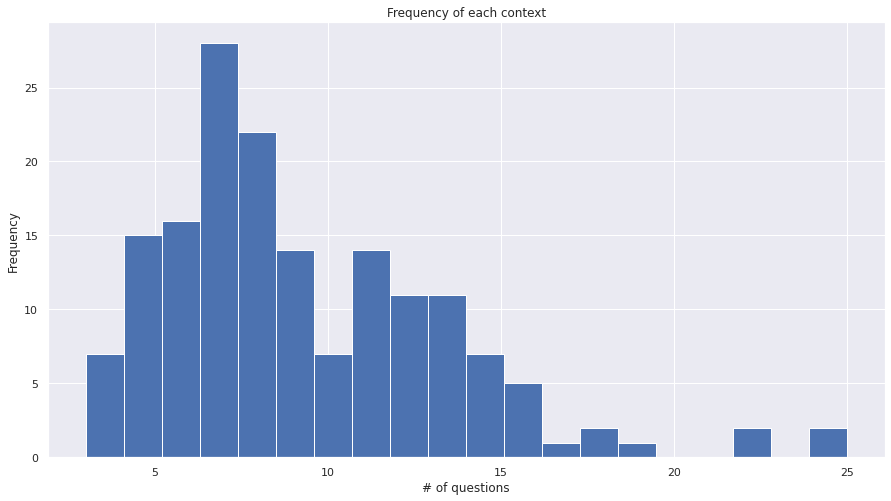

In [36]:
document_count=list(df.groupby('title').count().sort_values('category')['question'])

plt.xlabel("# of questions")
plt.ylabel("Frequency")
plt.title("Frequency of each context")
plt.hist(document_count,bins=20)
plt.show()

## 회의록
- 165개의 회의록의 데이터(전체 데이터에서 `완주군` 데이터만 사용)
- 회의록에서 Agenda의 최소개수는 3개, 최대 개수는 12개

In [140]:
wanju_df=pd.read_csv('../data/raw_data/wanju.csv')

In [141]:
wanju_df

,uid,title,region,context,summary,total
0,1000,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제207회 완주군의회 임시회 제...,제207회 완주군의회 임시회 제1차 본회의 개의 선포.,@제207회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의석을 정돈하여 주시...
1,1001,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,의사팀장 수고하셨습니다. 먼저 의사일정 제1항 제207회 완주군의회 임시회 회기 결...,제207회 완주군의회 임시회 회기는 8월 26일부터 9월 4일까지 10일간으로 가결됨.,@제207회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사팀장 수고하셨습니...
2,1002,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제2항 제207회 완주군의회 임시회 회의록 서명의원 선출의 건을 상...,제207회 완주군의회 임시회 회의록 서명의원으로 최등원 의원과 박웅배 의원이 선출됨.,@제207회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n다음은 의사일정 제2...
3,1003,제207회 완주군의회(임시회) 제 1 차 본회의회의록,완주,다음은 의사일정 제3항 본회의 휴회의 건을 상정합니다. 상임의원회 의정활동을 위하여...,8월 27일부터 9월 3일까지 8일간 휴회가 가결됨. 제2차 본회의는 9월 4일 오...,@제207회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n다음은 의사일정 제3...
4,1004,제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록,완주,의석을 정돈하여 주시기 바랍니다. 성원이 되었으므로 제251회 완주군의회 제1차 정...,제251회 완주군의회 제1차 정례회 제1차 본회의 개의 선포.,@제251회 완주군의회(제1차 정례회) 제1차 본 회 의 회 의 록@\n\n의석을 ...
...,...,...,...,...,...,...
856,3973,제204회 완주군의회(임시회) 제 1 차 본회의회의록,완주,성원이 되었으므로 제204회 완주군의회 임시회 제1차 본회의 개의를 선포합니다. 먼...,제204회 완주군의회 임시회 제1차 본회의 개의 선포. 금번 임시회는 서남용 의원 ...,@제204회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n성원이 되었으므로 제...
857,3974,제204회 완주군의회(임시회) 제 1 차 본회의회의록,완주,"의사일정 제1항, 제204회 완주군의회 임시회 회기결정의 건을 상정합니다.\n\n제...",제204회 완주군의회 임시회 회기는 4월 22일부터 4월 28일까지 7일간으로 가결됨.,"@제204회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n의사일정 제1항, 제..."
858,3975,제204회 완주군의회(임시회) 제 1 차 본회의회의록,완주,"다음은 의사일정 제2항, 제204회 완주군의회 임시회 회의록 서명의원 선출의 건을 ...",제204회 완주군의회 임시회 회의록 서명의원으로 김용찬 의원과 류영렬 의원이 선출됨.,@제204회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n다음은 의사일정 제2...
859,3976,제204회 완주군의회(임시회) 제 1 차 본회의회의록,완주,"다음은 의사일정 제3항, 2014회계연도 결산검사위원 선임의 건을 상정합니다.본 건...","2014회계연도 결산검사위원으로 대표의원 이인숙 의원, 전직 공무원 김상철, 임재평...",@제204회 완주군의회(임시회) 제 1 차 본회의회의록@\n\n다음은 의사일정 제3...


In [142]:
agenda_count=list(wanju_df.groupby('title').count()['uid'])

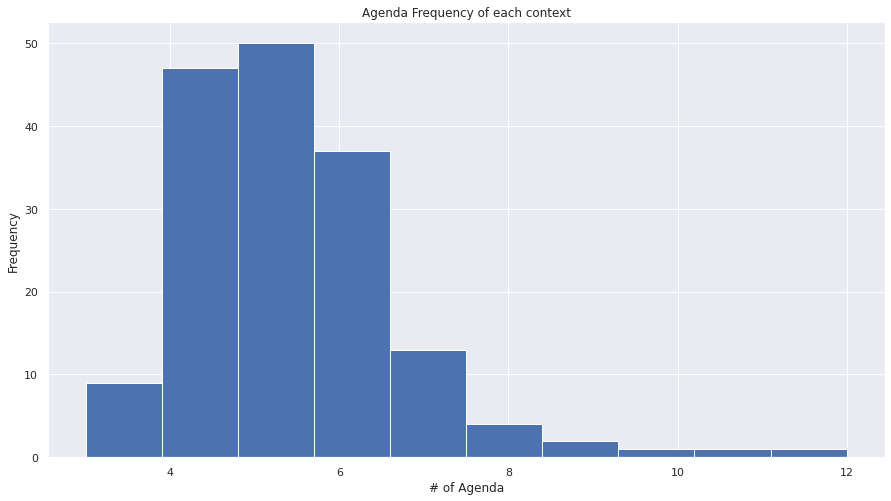

In [143]:
plt.xlabel("# of Agenda")
plt.ylabel("Frequency")
plt.title("Agenda Frequency of each context")
plt.hist(agenda_count,bins=10)
plt.show()